In [ ]:
!pip install pandas pykeen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00


In [ ]:
from google.colab import files
#uploaded = files.upload()
#extracted_tripletsRebel-2000.csv

In [ ]:
import pandas as pd
from pykeen.triples import TriplesFactory
import numpy as np
from pykeen.pipeline import pipeline
from pykeen.evaluation import RankBasedEvaluator
import pickle

# KG Rebel con nodo padre noticia, para enlazado a cada entidad
#Rebel>
csv_file = '/content/KGRebel-ds2k (3).csv'

#StandFord>
#csv_file = '/content/KG_Standford_2k.csv'
df = pd.read_csv(csv_file)
df = df.drop(index=0)
df.columns = ['head', 'relation', 'tail']

df['head'] = df['head'].astype(str)
df['relation'] = df['relation'].astype(str)
df['tail'] = df['tail'].astype(str)

triples_factory = TriplesFactory.from_labeled_triples(
    triples=df[['head', 'relation', 'tail']].values,
)

training, testing, validation = triples_factory.split([0.8, 0.1, 0.1])

with open('training_triples_TransEStand2K.pkl', 'wb') as f:
    pickle.dump(training, f)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [8282, 3719, 3720]


In [ ]:
result = pipeline(
    model='TransE',
    loss="nssa",
    training=training,
    testing=testing,
    validation=validation,
    model_kwargs=dict(
        embedding_dim=100,
    ),
    optimizer="adam",
    optimizer_kwargs=dict(
        lr=0.002,
    ),
    training_kwargs=dict(
        num_epochs=100,
        batch_size=32,
        use_tqdm_batch=False,
    ),
    negative_sampler="basic",
    negative_sampler_kwargs=dict(
        num_negs_per_pos=1,
    ),
    regularizer="LP",
    regularizer_kwargs=dict(
        p=2,
        weight=1e-5,
    ),
    loss_kwargs=dict(
        margin=10,
    ),
    device="cuda",
)

INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Evaluating on cuda:0:   0%|          | 0.00/3.72k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.81s seconds


Evaluating on cuda:0:   0%|          | 0.00/3.72k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.72s seconds


Hits@1: 0.059424576499058884
Hits@3: 0.3542618983597741
Hits@5: 0.4123420274267276
Hits@10: 0.4817155149233665
Mean Reciprocal Rank: 0.22691088914871216


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='nssa Loss'>

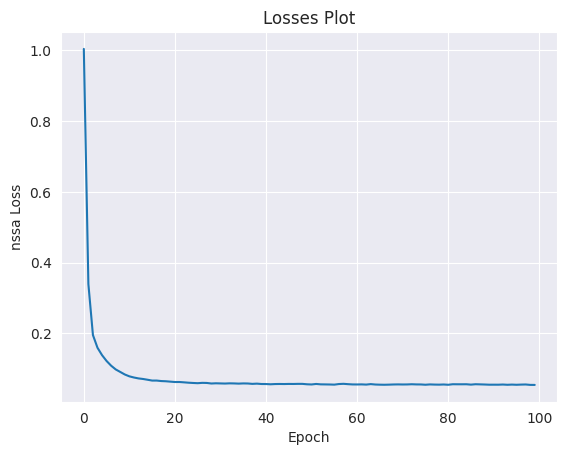

In [ ]:
evaluator = RankBasedEvaluator()

metrics = evaluator.evaluate(result.model, testing.mapped_triples, additional_filter_triples=[training.mapped_triples, validation.mapped_triples])

print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")
result.plot_losses()

In [ ]:
# Guardar el modelo entrenado
model = result.model
output_dir = '/content/Tesis-RAGS/'
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
os.chdir(output_dir)
result.save_model('model_TransE_R2K.pkl')

print("Modelo y training guardados exitosamente.")

Modelo y training guardados exitosamente.


# .

In [ ]:
result = pipeline(
    model='TransE',
    loss="nssa",  # Nombre correcto para la pérdida adversarial negativa
    training=training,
    testing=testing,
    validation=validation,
    model_kwargs=dict(
        embedding_dim=100,  # Ajustar la  dimensionalidad a k=100
    ),
    optimizer="adam",  # Optimizer ajustado
    optimizer_kwargs=dict(
        lr=0.002,  # Learning rate ajustado
    ),
    training_kwargs=dict(
        num_epochs=200,  # Ajustar a 200 épocas
        batch_size=32,  # Ajustar el tamaño de batch
        use_tqdm_batch=False,
    ),
    negative_sampler="basic",  # Configurar el muestreo negativo como básico
    negative_sampler_kwargs=dict(
        num_negs_per_pos=1,  # Número de ejemplos negativos por positivo
    ),
    regularizer="LP",  # Ajustar regularizador a LP
    regularizer_kwargs=dict(
        p=2,  # Regularizer p2
        weight=1e-5,  # Lambda ajustado
    ),
    loss_kwargs=dict(
        margin=10,  # Margin ajustado
    ),
    device="cuda",  # Especificar que se usará GPU
)


In [ ]:
print("Dispositivo del modelo:", next(result.model.parameters()).device)
print("Dispositivo de las triplas:", testing.mapped_triples.device)

In [ ]:
# Create an evaluator
evaluator = RankBasedEvaluator()

# Evaluate the model
metrics = evaluator.evaluate(result.model, testing.mapped_triples, additional_filter_triples=[training.mapped_triples, validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")
result.plot_losses()

In [ ]:

# Guardar el modelo entrenado
model = result.model
output_dir = '/content/Tesis-RAGS/'
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
os.chdir(output_dir)
result.save_model('model_TransE_Stand2K_Hype.pkl')

print("Modelo y training guardados exitosamente.")

In [ ]:
ENDDD

In [ ]:
import torch
import pandas as pd
import numpy as np
import pickle
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.datasets import get_dataset

In [ ]:
model = torch.load('model_Standford_1k.pkl')

<ipython-input-10-f239ff1d462a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model_Standford_1k.pkl')


In [ ]:

model = torch.load('model_Standford_1k.pkl')

<ipython-input-15-f239ff1d462a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model_Standford_1k.pkl')


In [ ]:

with open('training_triples_TransEStand2K.pkl', 'rb') as f:
    training = pickle.load(f)

In [ ]:
from pykeen.evaluation import RankBasedEvaluator
 # Create an evaluator
evaluator = RankBasedEvaluator()

# Evaluate the model
metrics = evaluator.evaluate(model, testing.mapped_triples, additional_filter_triples=[training.mapped_triples, validation.mapped_triples])


# Imprimir los resultados
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
